# Unsupervised Learning and Convolutional Autoencoder for Image Anomaly Detection

In [98]:
# import packages

import pandas as pd
import numpy as np
from scipy import stats
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.preprocessing import StandardScaler
from pylab import rcParams
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, InputLayer
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

In [2]:
from keras.datasets import fashion_mnist
from keras.datasets import mnist

#### the autoencoder reconstructs the normal data with a smaller error

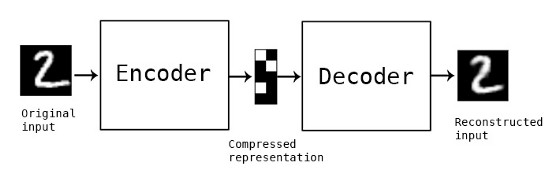

#### the anomaly data with a larger error

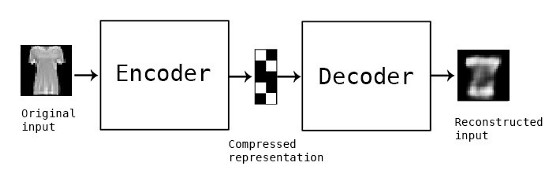

#### Use the reconstruction error to identify anomaly

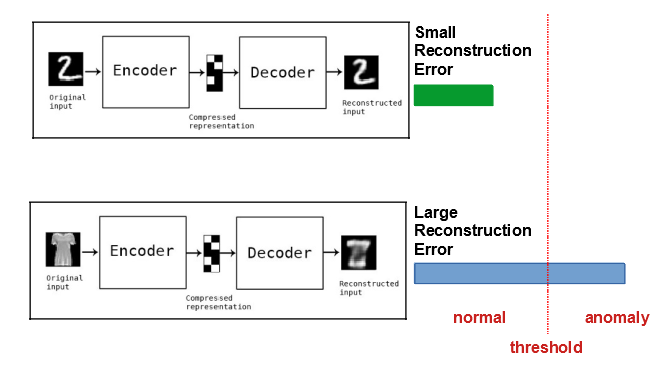

## Load Dataset

#### MNIST Data

In [12]:
(X_train_1, y_train_1), (X_test_1, y_test_1) = mnist.load_data()
print (X_train_1.shape)
print (X_test_1.shape)
print (y_train_1.shape)
print (y_test_1.shape)

(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)


In [13]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_test_1, y_test_1, test_size=0.1)
print (X_train_1.shape)
print (X_test_1.shape)
print (y_train_1.shape)
print (y_test_1.shape)

(9000, 28, 28)
(1000, 28, 28)
(9000,)
(1000,)


#### Fashion MNIST

In [14]:
(X_train_2, y_train_2), (X_test_2, y_test_2) = fashion_mnist.load_data()
print (X_train_2.shape)
print (y_train_2.shape)
print (X_test_2.shape)
print (y_test_2.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [15]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_test_2, y_test_2, test_size=0.1)
print (X_train_2.shape)
print (y_train_2.shape)
print (X_test_2.shape)
print (y_test_2.shape)

(9000, 28, 28)
(9000,)
(1000, 28, 28)
(1000,)


#### Prepare Dataset

In [24]:
X_test = np.concatenate((X_test_1, X_test_2))
y_test = np.concatenate((y_test_1, y_test_2))
print (X_test.shape)
print (y_test.shape)

(2000, 28, 28)
(2000,)


#### We will normalize all values between 0 and 1 and we will flatten the 28x28 images into vectors of size 784.

In [27]:
x_train = X_train_1.astype('float32') / 255.
x_test = X_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print (x_train.shape)
print (x_test.shape)

(9000, 784)
(2000, 784)


## Build Model

### Simplest possible autoencoder
a single fully-connected neural layer as encoder and as decoder

In [ ]:
# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

In [ ]:
# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

### Deep autoencoder

In [43]:
input_img = Input(shape=(784,))
encoded = Sequential()
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)

encoded = Dense(32, activation='relu')(encoded)

decoded = Sequential()
decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

In [44]:
autoencoder = Model(input_img, decoded)
autoencoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_10 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_11 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_12 (Dense)             (None, 784)               1011

In [45]:
#autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.compile(optimizer='adamax', loss='mse')

h = autoencoder.fit(x_train, x_train,
                epochs=25,
                batch_size=32,
                shuffle=True,
                verbose=0,
                #validation_data=(x_test, x_test),
                validation_split=0.2)

Text(0.5, 0, 'Epochs')

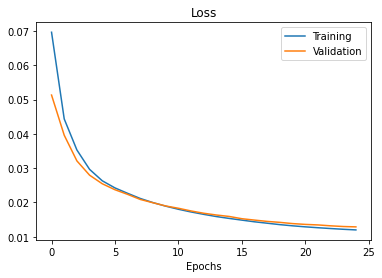

In [46]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Loss')
plt.xlabel('Epochs')

In [120]:
def visualize(img,autoencoder):
    """Draws original, encoded and decoded images"""
    #code = encoded.predict(img[None])[0]
    reco = autoencoder.predict(img[None])[0]

    plt.subplot(1,2,1)
    plt.title("Original")
    plt.imshow(np.clip(img.reshape(28,28) + 0.5, 0, 1))

#     plt.subplot(1,3,2)
#     plt.title("Code")
#     plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,2,2)
    plt.title("Reconstructed")
    plt.imshow(np.clip(reco.reshape(28,28) + 0.5, 0, 1))
    
    plt.show()

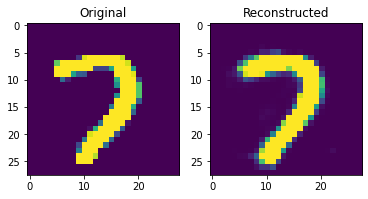

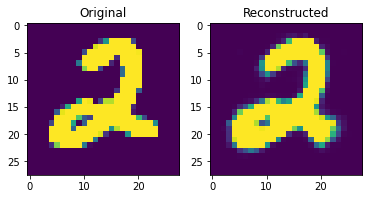

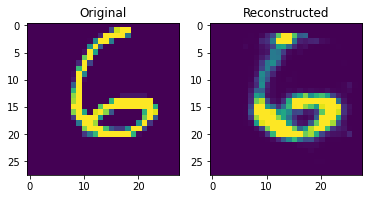

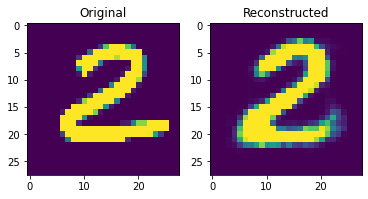

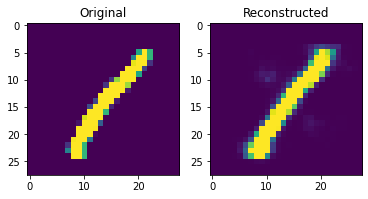

In [111]:
for i in range(5):
    img = x_test[i]
    visualize(img,autoencoder)

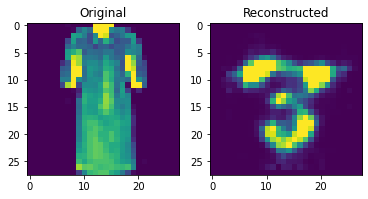

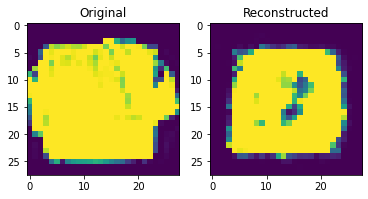

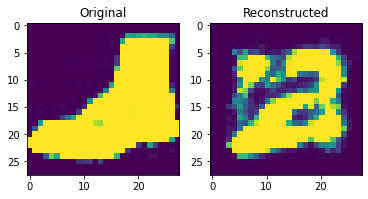

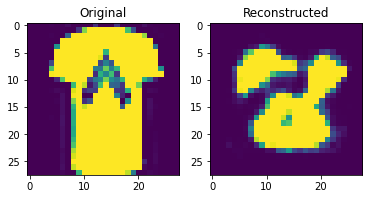

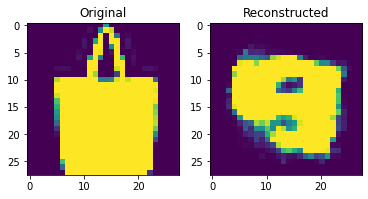

In [119]:
for i in range(5):
    img = x_test[i-5]
    visualize(img,autoencoder)

In [121]:
imgtest = x_test[-5]

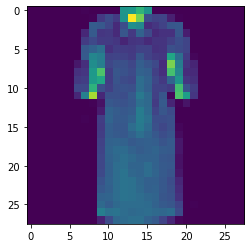

In [122]:
plt.imshow(imgtest.reshape(28,28))

In [123]:
reco_test = autoencoder.predict(imgtest[None])[0]

In [127]:
test_x_predictions = autoencoder.predict(x_test)
mse = np.mean(np.power(x_test - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse})

In [128]:
error_df.head()

,Reconstruction_error
0,0.006871
1,0.011237
2,0.018040
3,0.023587
4,0.004558


In [129]:
error_df.tail()

,Reconstruction_error
1995,0.031080
1996,0.098764
1997,0.122219
1998,0.133336
1999,0.159213
